# EDA and preprocessing of the azimuth dataset

In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import anndata2ri


from lab_scripts.data.preprocessing.common import gex_normalization
from lab_scripts.data.preprocessing.common import gex_qc

sc.settings.verbosity = 3  # show info messages
sc.set_figure_params(figsize=(5, 3))  # set figsize for plots


# GEX preprocessing

In [2]:
data = ad.read_h5ad("data/raw/gex_adt/azimuth_gex.h5ad")
data

AnnData object with n_obs × n_vars = 161764 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'batch', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'seq_batch', 'cell_type'
    var: 'names', 'feature_types'
    uns: 'dataset_id', 'organism'

In [3]:
# 8 batches
data.obs['batch'].unique()

['P2', 'P1', 'P4', 'P3', 'P5', 'P7', 'P6', 'P8']
Categories (8, object): ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']

In [4]:
# 2 sequence batches
data.obs['seq_batch'].unique()

['Batch1', 'Batch2']
Categories (2, object): ['Batch1', 'Batch2']

In [5]:
batches = data.obs[['seq_batch', 'batch']]
batches

,seq_batch,batch
L1_AAACCCAAGAAACTCA,Batch1,P2
L1_AAACCCAAGACATACA,Batch1,P1
L1_AAACCCACAACTGGTT,Batch1,P4
L1_AAACCCACACGTACTA,Batch1,P3
L1_AAACCCACAGCATACT,Batch1,P4
...,...,...
E2L8_TTTGTTGGTCGTGATT,Batch2,P5
E2L8_TTTGTTGGTGTGCCTG,Batch2,P5
E2L8_TTTGTTGGTTAGTTCG,Batch2,P8
E2L8_TTTGTTGGTTGGCTAT,Batch2,P5


In [6]:
seq_to_batch = {
    'Batch1': set(),
    'Batch2': set()
}

for observation in batches.iterrows():
    seq_batch = observation[1]['seq_batch']
    batch = observation[1]['batch']
    seq_to_batch[seq_batch].add(batch)

seq_to_batch

{'Batch1': {'P1', 'P2', 'P3', 'P4'}, 'Batch2': {'P5', 'P6', 'P7', 'P8'}}

In [7]:
data.obs

,nCount_RNA,nFeature_RNA,orig.ident,lane,batch,time,celltype.l1,celltype.l2,celltype.l3,Phase,seq_batch,cell_type
L1_AAACCCAAGAAACTCA,10823,2915,SeuratProject,L1,P2,7,Mono,CD14 Mono,CD14 Mono,G1,Batch1,CD14 Mono
L1_AAACCCAAGACATACA,5864,1617,SeuratProject,L1,P1,7,CD4 T,CD4 TCM,CD4 TCM_1,G1,Batch1,CD4 TCM
L1_AAACCCACAACTGGTT,5067,1381,SeuratProject,L1,P4,2,CD8 T,CD8 Naive,CD8 Naive,S,Batch1,CD8 Naive
L1_AAACCCACACGTACTA,4786,1890,SeuratProject,L1,P3,7,NK,NK,NK_2,G1,Batch1,NK
L1_AAACCCACAGCATACT,6505,1621,SeuratProject,L1,P4,7,CD8 T,CD8 Naive,CD8 Naive,G1,Batch1,CD8 Naive
...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,9346,2201,SeuratProject,E2L8,P5,7,CD8 T,CD8 Naive,CD8 Naive,S,Batch2,CD8 Naive
E2L8_TTTGTTGGTGTGCCTG,9318,2938,SeuratProject,E2L8,P5,2,Mono,CD14 Mono,CD14 Mono,G1,Batch2,CD14 Mono
E2L8_TTTGTTGGTTAGTTCG,11619,3224,SeuratProject,E2L8,P8,0,B,B intermediate,B intermediate kappa,S,Batch2,B intermediate
E2L8_TTTGTTGGTTGGCTAT,15436,3999,SeuratProject,E2L8,P5,2,Mono,CD16 Mono,CD16 Mono,G1,Batch2,CD16 Mono


In [8]:
data = gex_qc.calculate_mito_fraction(data)
data

AnnData object with n_obs × n_vars = 161764 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'batch', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'seq_batch', 'cell_type', 'pct_counts_mt'
    var: 'names', 'feature_types'
    uns: 'dataset_id', 'organism'

## Basic QC

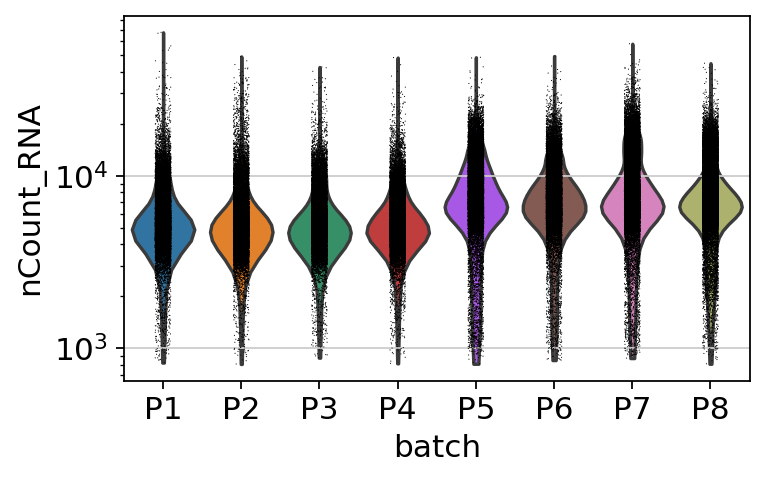

In [9]:
t1 = sc.pl.violin(data, 'nCount_RNA', groupby='batch', size=0.5, log=True)

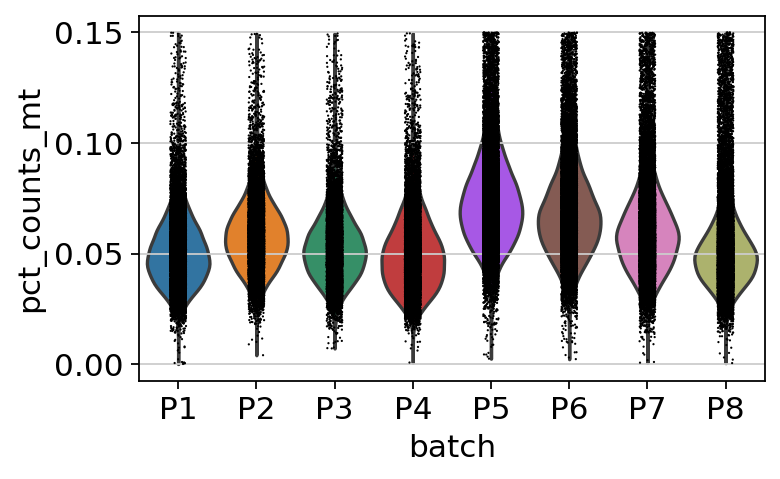

In [10]:
t2 = sc.pl.violin(data, 'pct_counts_mt', groupby='batch')

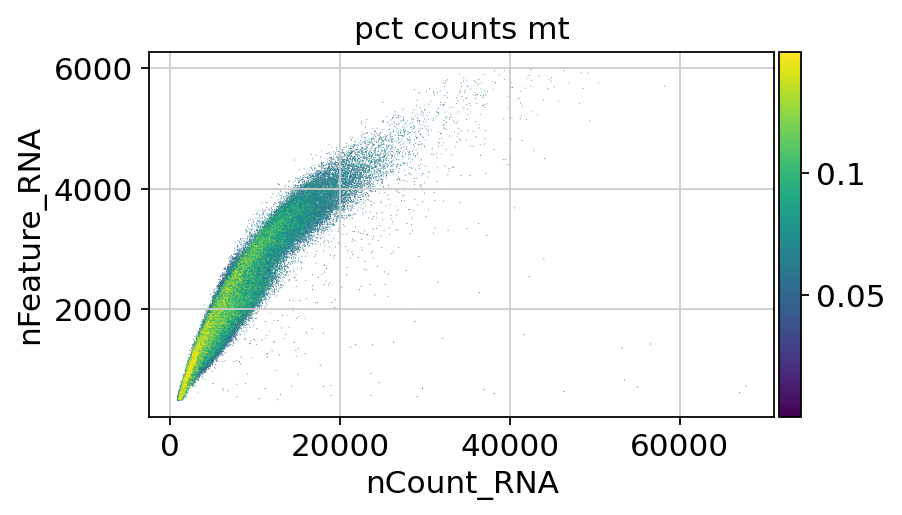

In [11]:
p1 = sc.pl.scatter(data, 'nCount_RNA', 'nFeature_RNA', color='pct_counts_mt')

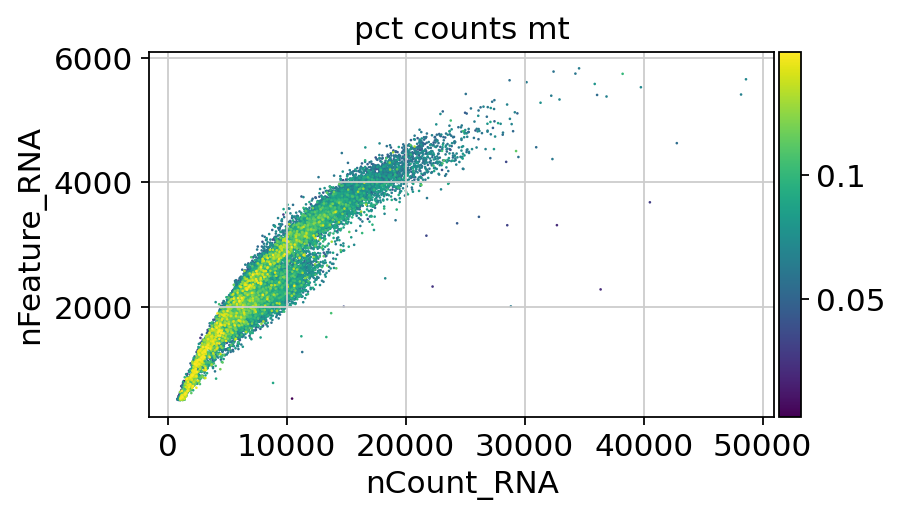

In [12]:
# Let's look at the worst batch
p1 = sc.pl.scatter(data[data.obs['batch'] == 'P5'], 'nCount_RNA', 'nFeature_RNA', color='pct_counts_mt')

/home/simon/miniconda3/envs/nips/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


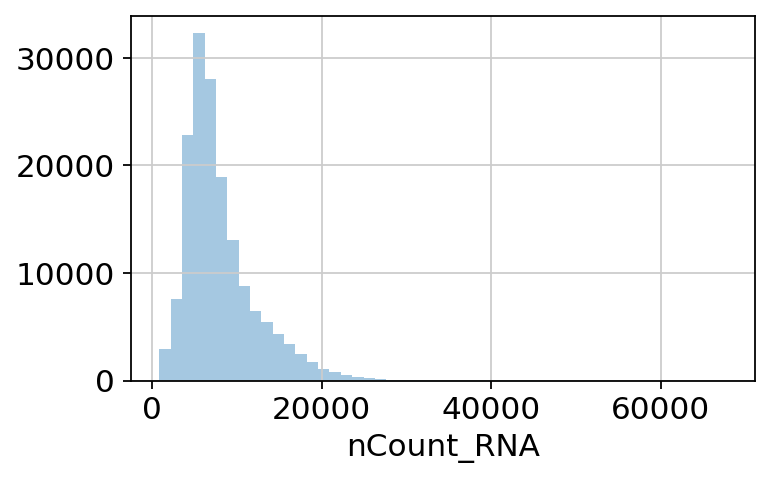

In [13]:
p3 = sns.distplot(data.obs['nCount_RNA'], kde=False)

In [14]:
sc.pp.filter_cells(data, max_counts=20000)

filtered out 3095 cells that have more than 20000 counts


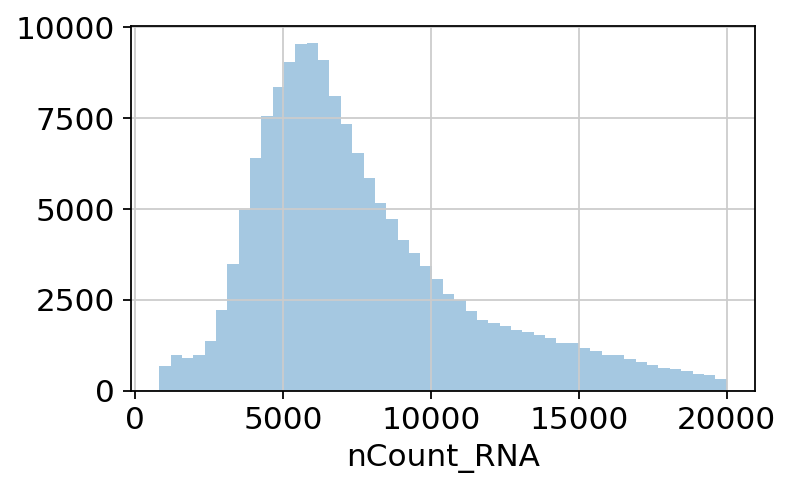

In [15]:
p3 = sns.distplot(data.obs['nCount_RNA'], kde=False)

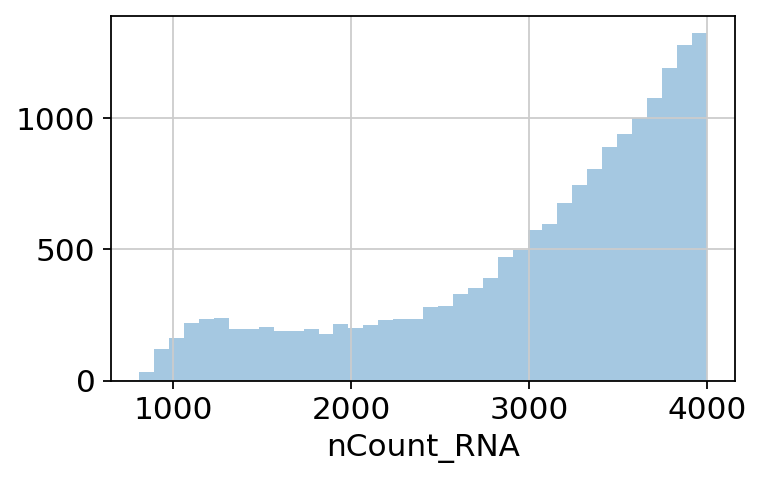

In [16]:
p4 = sns.distplot(data.obs['nCount_RNA'][data.obs['nCount_RNA'] < 4000], kde=False)

In [17]:
sc.pp.filter_cells(data, min_counts=2000)

filtered out 2597 cells that have less than 2000 counts


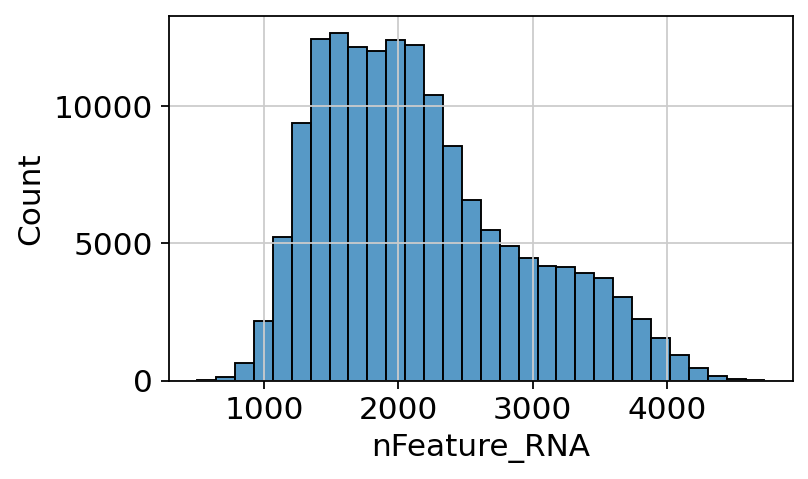

In [18]:
# Let's see how many cells express some genes
plot = sns.histplot(data.obs['nFeature_RNA'], bins=30)

In [19]:
data = gex_qc.calculate_n_cells(data)

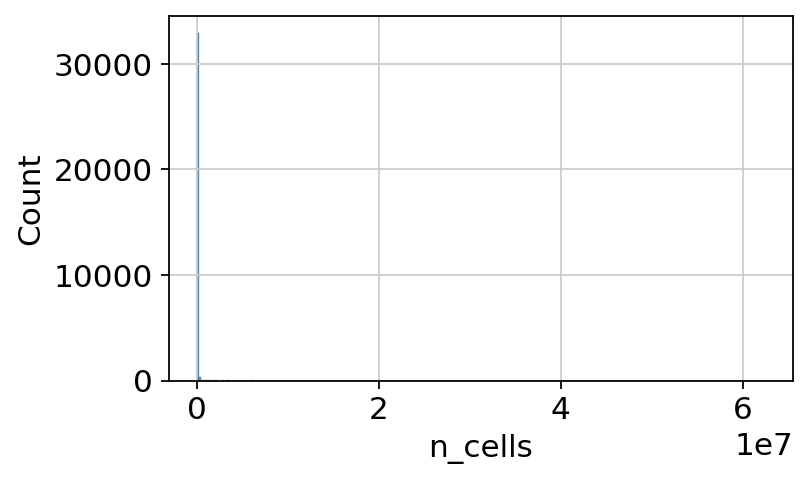

In [20]:
# Let's see how many cells express some genes
plot = sns.histplot(data.var['n_cells'], bins=300)

In [21]:
# There are many genes with no expression at all
(data.var['n_cells'] == 0.0).sum()

6185

In [22]:
sc.pp.filter_genes(data, min_cells=1)

filtered out 6185 genes that are detected in less than 1 cells


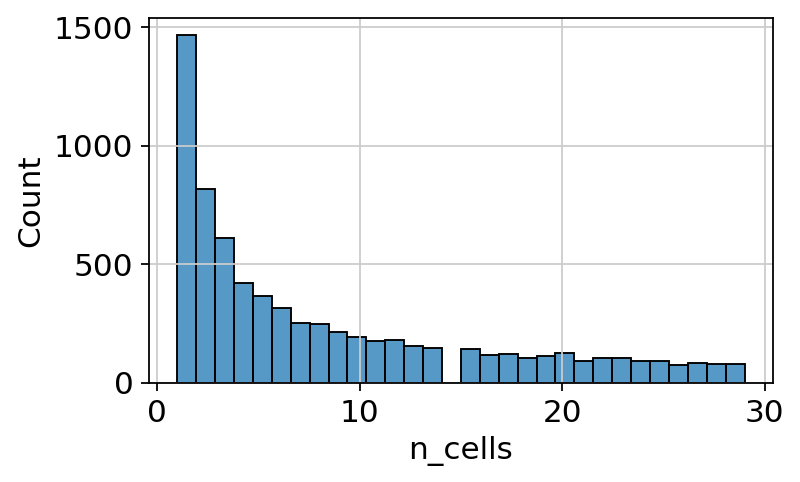

In [23]:
# Let's look again
plot = sns.histplot(data.var['n_cells'][data.var['n_cells'] < 30], bins=30)

In [24]:
# There are still many genes expressed in less than 20 cells
# Since we have 150k cells, let's discard them
sc.pp.filter_genes(data, min_cells=20)

filtered out 6149 genes that are detected in less than 20 cells


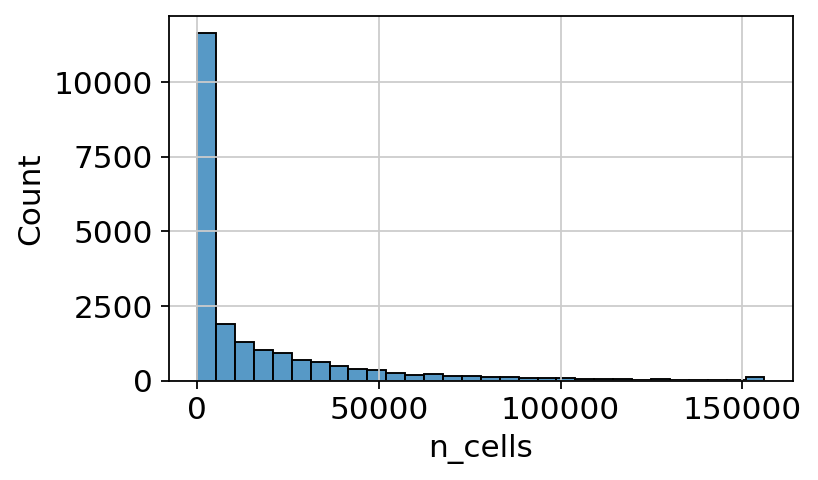

In [25]:
# Let's look again
plot = sns.histplot(data.var['n_cells'], bins=30)

normalizing counts per cell
    finished (0:00:01)


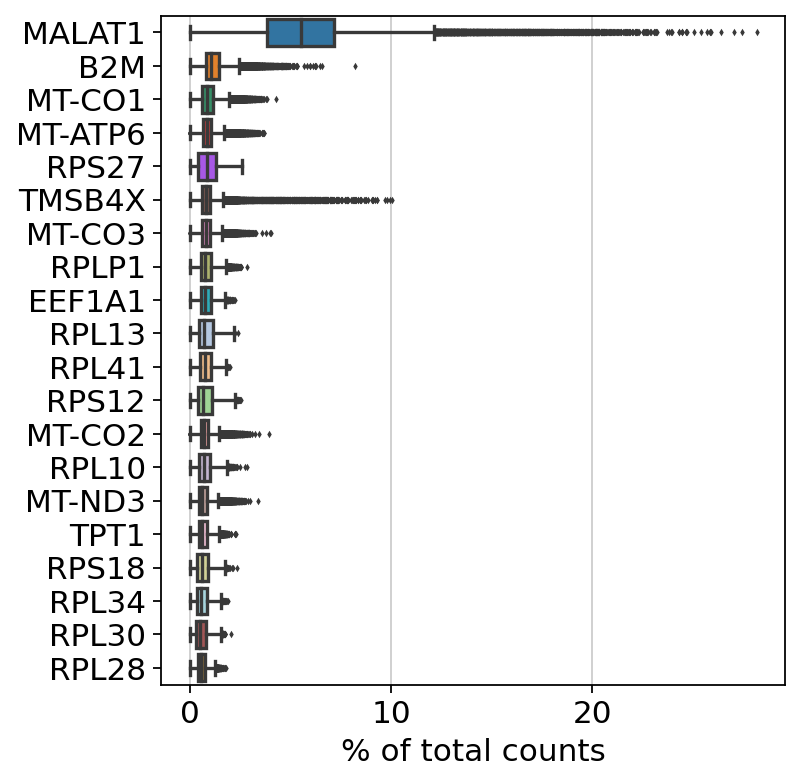

In [26]:
# Here is the highest expressed genes
sc.pl.highest_expr_genes(data, n_top=20, )

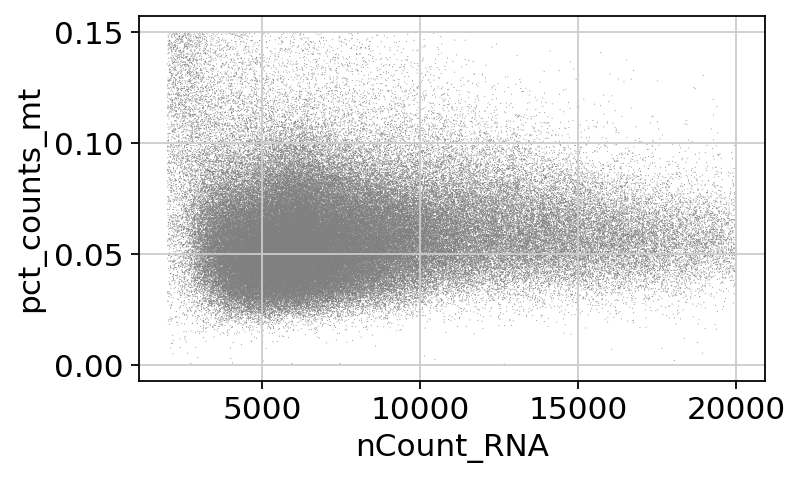

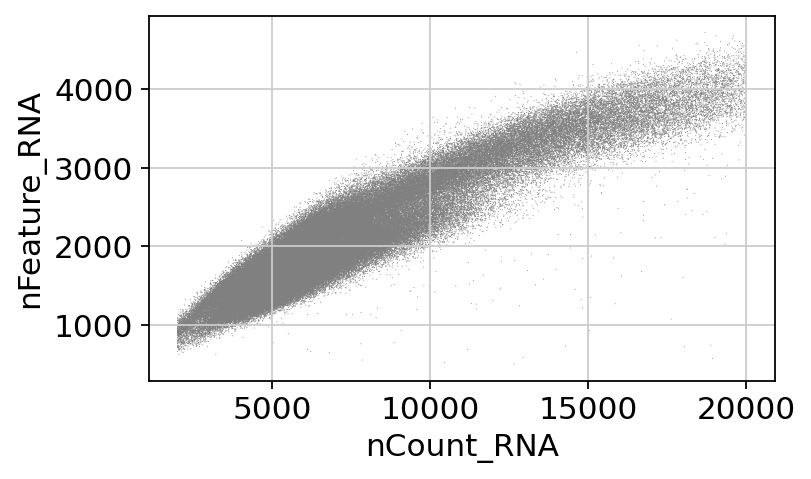

In [27]:
sc.pl.scatter(data, x='nCount_RNA', y='pct_counts_mt')
sc.pl.scatter(data, x='nCount_RNA', y='nFeature_RNA')

computing PCA
    with n_comps=50
    finished (0:01:44)


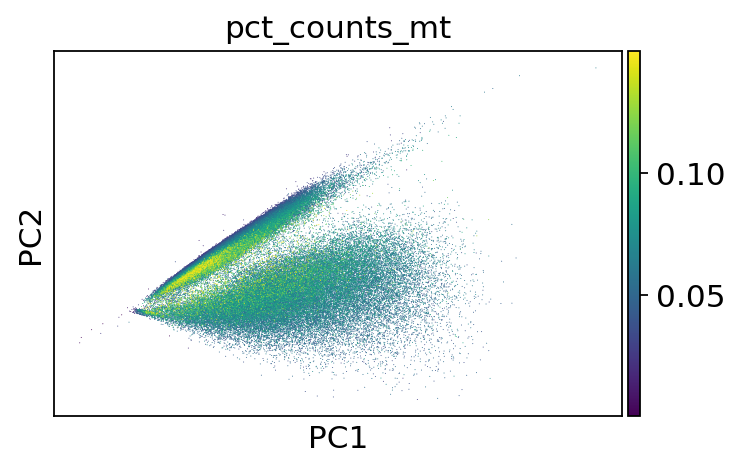

In [28]:
sc.tl.pca(data)
sc.pl.pca(data, color='pct_counts_mt')

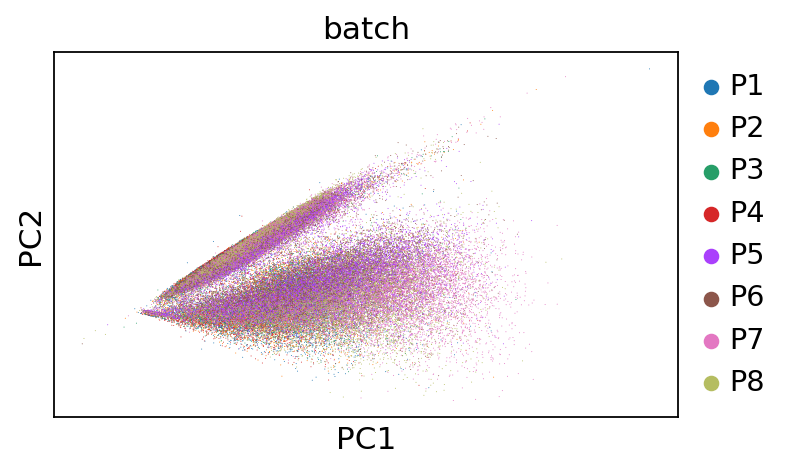

In [29]:
sc.pl.pca(data, color='batch')

In [30]:
data.obs['batch'].value_counts()

P8    25446
P7    24087
P5    20721
P6    20044
P1    17725
P4    16829
P2    16816
P3    14404
Name: batch, dtype: int64

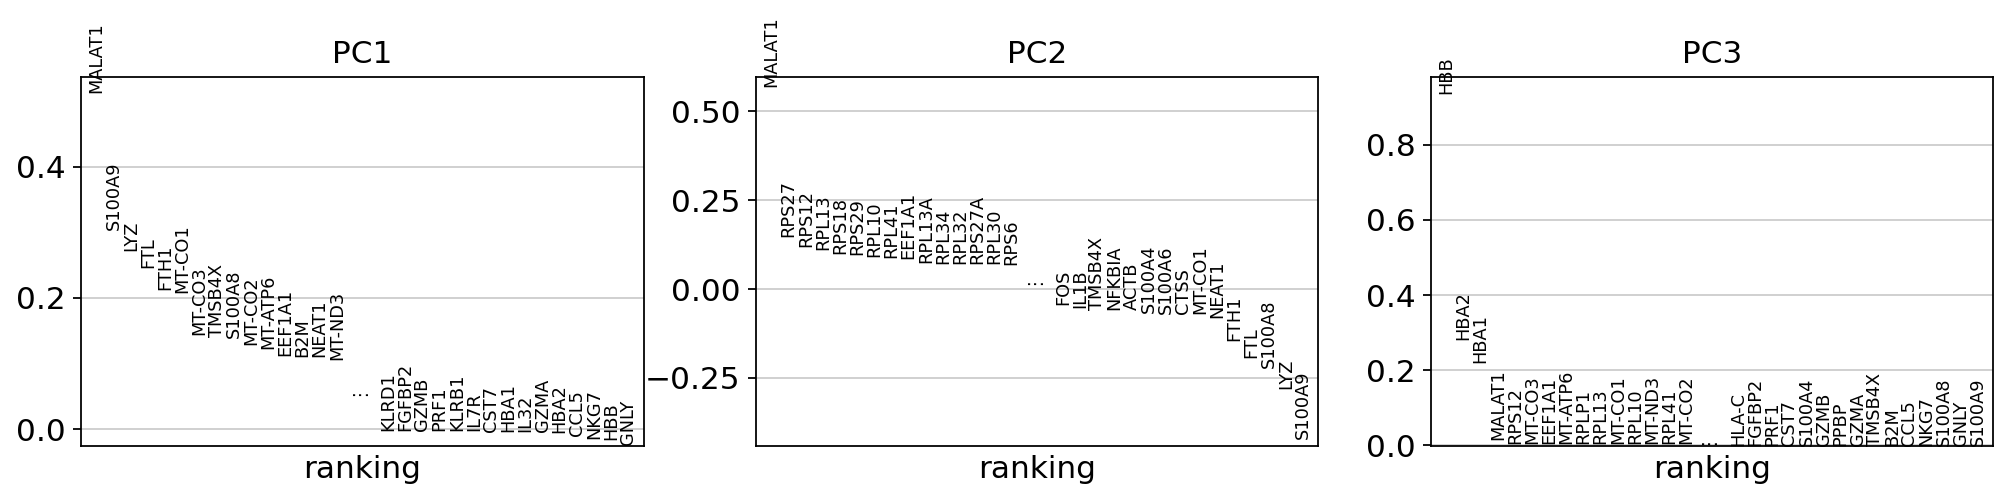

In [31]:
sc.pl.pca_loadings(data, components = '1,2,3')

## Normalization

In [32]:
all_batches = batches['batch'].unique()

In [36]:
size_factors = []
for batch in all_batches:
    print(batch)
    batch_data = data[data.obs['batch'] == batch]
    clusters = gex_normalization.get_clusters(batch_data)
    batch_data = gex_normalization.calculate_size_factors(batch_data, clusters)
    size_factors.append(batch_data.obs['size_factors'])

P2
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


Trying to set attribute `.obs` of view, copying.


P1
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:02)


Trying to set attribute `.obs` of view, copying.


P4
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


Trying to set attribute `.obs` of view, copying.


P3
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


Trying to set attribute `.obs` of view, copying.


P5
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


Trying to set attribute `.obs` of view, copying.


P7
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:03)


Trying to set attribute `.obs` of view, copying.


P6
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:02)


Trying to set attribute `.obs` of view, copying.


P8
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:03)


Trying to set attribute `.obs` of view, copying.


In [38]:
pd.concat(size_factors)

L1_AAACCCAAGAAACTCA      1.949541
L1_AAACCCATCTTAAGGC      0.765569
L1_AAACGAAAGATAACAC      0.506945
L1_AAACGAACAAGAGTAT      0.803078
L1_AAACGAATCCCGTTGT      0.718298
                           ...   
E2L8_TTTGGTTTCGTCAACA    0.937083
E2L8_TTTGTTGAGGCATGCA    0.756880
E2L8_TTTGTTGAGTAGAGTT    0.858803
E2L8_TTTGTTGCAGCGTGAA    0.793941
E2L8_TTTGTTGGTTAGTTCG    1.424253
Name: size_factors, Length: 156072, dtype: float64

In [40]:
data.obs['size_factors'] = pd.concat(size_factors)

In [41]:
data.obs

,nCount_RNA,nFeature_RNA,orig.ident,lane,batch,time,celltype.l1,celltype.l2,celltype.l3,Phase,seq_batch,cell_type,pct_counts_mt,n_counts,size_factors
L1_AAACCCAAGAAACTCA,10823,2915,SeuratProject,L1,P2,7,Mono,CD14 Mono,CD14 Mono,G1,Batch1,CD14 Mono,0.060242,10823.0,1.949541
L1_AAACCCAAGACATACA,5864,1617,SeuratProject,L1,P1,7,CD4 T,CD4 TCM,CD4 TCM_1,G1,Batch1,CD4 TCM,0.033083,5864.0,0.772621
L1_AAACCCACAACTGGTT,5067,1381,SeuratProject,L1,P4,2,CD8 T,CD8 Naive,CD8 Naive,S,Batch1,CD8 Naive,0.048747,5067.0,0.703442
L1_AAACCCACACGTACTA,4786,1890,SeuratProject,L1,P3,7,NK,NK,NK_2,G1,Batch1,NK,0.050773,4786.0,1.047459
L1_AAACCCACAGCATACT,6505,1621,SeuratProject,L1,P4,7,CD8 T,CD8 Naive,CD8 Naive,G1,Batch1,CD8 Naive,0.040738,6505.0,0.830579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,9346,2201,SeuratProject,E2L8,P5,7,CD8 T,CD8 Naive,CD8 Naive,S,Batch2,CD8 Naive,0.072223,9346.0,0.807198
E2L8_TTTGTTGGTGTGCCTG,9318,2938,SeuratProject,E2L8,P5,2,Mono,CD14 Mono,CD14 Mono,G1,Batch2,CD14 Mono,0.061387,9318.0,1.149545
E2L8_TTTGTTGGTTAGTTCG,11619,3224,SeuratProject,E2L8,P8,0,B,B intermediate,B intermediate kappa,S,Batch2,B intermediate,0.072037,11619.0,1.424253
E2L8_TTTGTTGGTTGGCTAT,15436,3999,SeuratProject,E2L8,P5,2,Mono,CD16 Mono,CD16 Mono,G1,Batch2,CD16 Mono,0.057010,15436.0,1.965212


In [42]:
import gc
gc.collect()

29587

In [44]:
data = gex_normalization.normalize(data)

In [ ]:
data

Error: Kernel is dead